In [2]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import scipy as sc
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#import stormeunice as eun
import warnings
import glob
#import tqdm

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)

In [4]:
#Define domain--all of UK

lon_min = -15
lon_max = 20
lat_min = 30
lat_max = 65



Import EPS data to show EPS prediction 

In [27]:

class Data():
    def get_eps_data(experiments, inidate='2022-02-16'):
        """
        Function to load comlete data of simulations on surface level since
        xr has a bug that prevents using
        this as a simpler solution

        Input:
        ------
        experiments: list of strings, list of experiments to import,
                e.g. ['pi', 'curr', 'incr']

        Output:
        -------
        eps: list of xarrays, data and metadata of operational forecasts,
        each list entry is one experiment
        """

        directory = {'pi': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/pi/EU025/sfc/',
                    'curr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/',
                    'incr': '/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/EXP/incr/EU025/sfc/'}

        eps = {}
        for experiment in experiments:
            exp_eps = []
            for c, cont in enumerate(['cf', 'pf']):
                for files in glob.glob(directory[experiment]
                                        + cont + '/*'
                                        + inidate + '*.nc'):
                    print(files)
                    data = xr.open_dataset(files)
                    exp_eps.append(Data.preproc_ds(data.get(['fg10', 'msl',
                                                                'u10', 'v10',
                                                                'u100', 'v100'])))

            eps[experiment] = xr.concat(exp_eps, dim='number').squeeze()

        return eps
    

    def preproc_ds(ds):
        """
        Main pre-processing function
        Writtten by Nick Leach.

        Input:
        ------

        Output:
        -------
        """

        # accumulated variables & scaling factors
        accumulated_vars = {'tp': 60 * 60 * 24 * 1e3,
                            'ttr': 1,
                            'tsr': 1,
                            'str': 1,
                            'ssr': 1,
                            'e': 1}
        accumulated_var_newunits = {'tp': 'mm day$^{-1}$',
                                    'ttr': 'W m$^{-2}$',
                                    'tsr': 'W m$^{-2}$',
                                    'str': 'W m$^{-2}$',
                                    'ssr': 'W m$^{-2}$',
                                    'e': 'm s$^{-1}$'}
        ds = ds.copy().squeeze()
        # set up aux data
        inidate = pd.to_datetime(ds.time[0].values)
        # expand dimensions to include extra info
        if not 'hDate' in ds:
            ds = ds.expand_dims({'inidate': [inidate]}).copy()

        if not 'number' in ds:
            ds = ds.expand_dims({'number': [0]}).copy()

        # put time dimension at front
        ds = ds.transpose('time', ...)
        ds = ds.copy(deep=True)

        # convert accumulated variables into instantaneous
        for var, sf in accumulated_vars.items():
            if var in ds.keys():
                ds[var].loc[dict(time=ds.time[1:])] = Data.accum2rate(ds[var]) * sf
                # set first value to equal zero,
                # should be zero but isn't always
                ds[var].loc[dict(time=ds.time[0])] = 0
                ds[var].attrs['units'] = accumulated_var_newunits[var]
        return ds
        

In [52]:
inidate = ['2022-02-10','2022-02-14','2022-02-16']
eps_msl = {}
for id in inidate:
    eps_msl[id] = Data.get_eps_data(['curr'],inidate=id)['curr'].msl/100




/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-10.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-14.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/cf/1_2022-02-16.nc
/gf3/predict2/AWH012_LEACH_NASTORM/DATA/MED-R/ENS/EU025/sfc/pf/1_2022-02-16.nc


In [53]:

    
p_max = 1040
p_min = 960

Get all era5 data during an interval and have a look at them

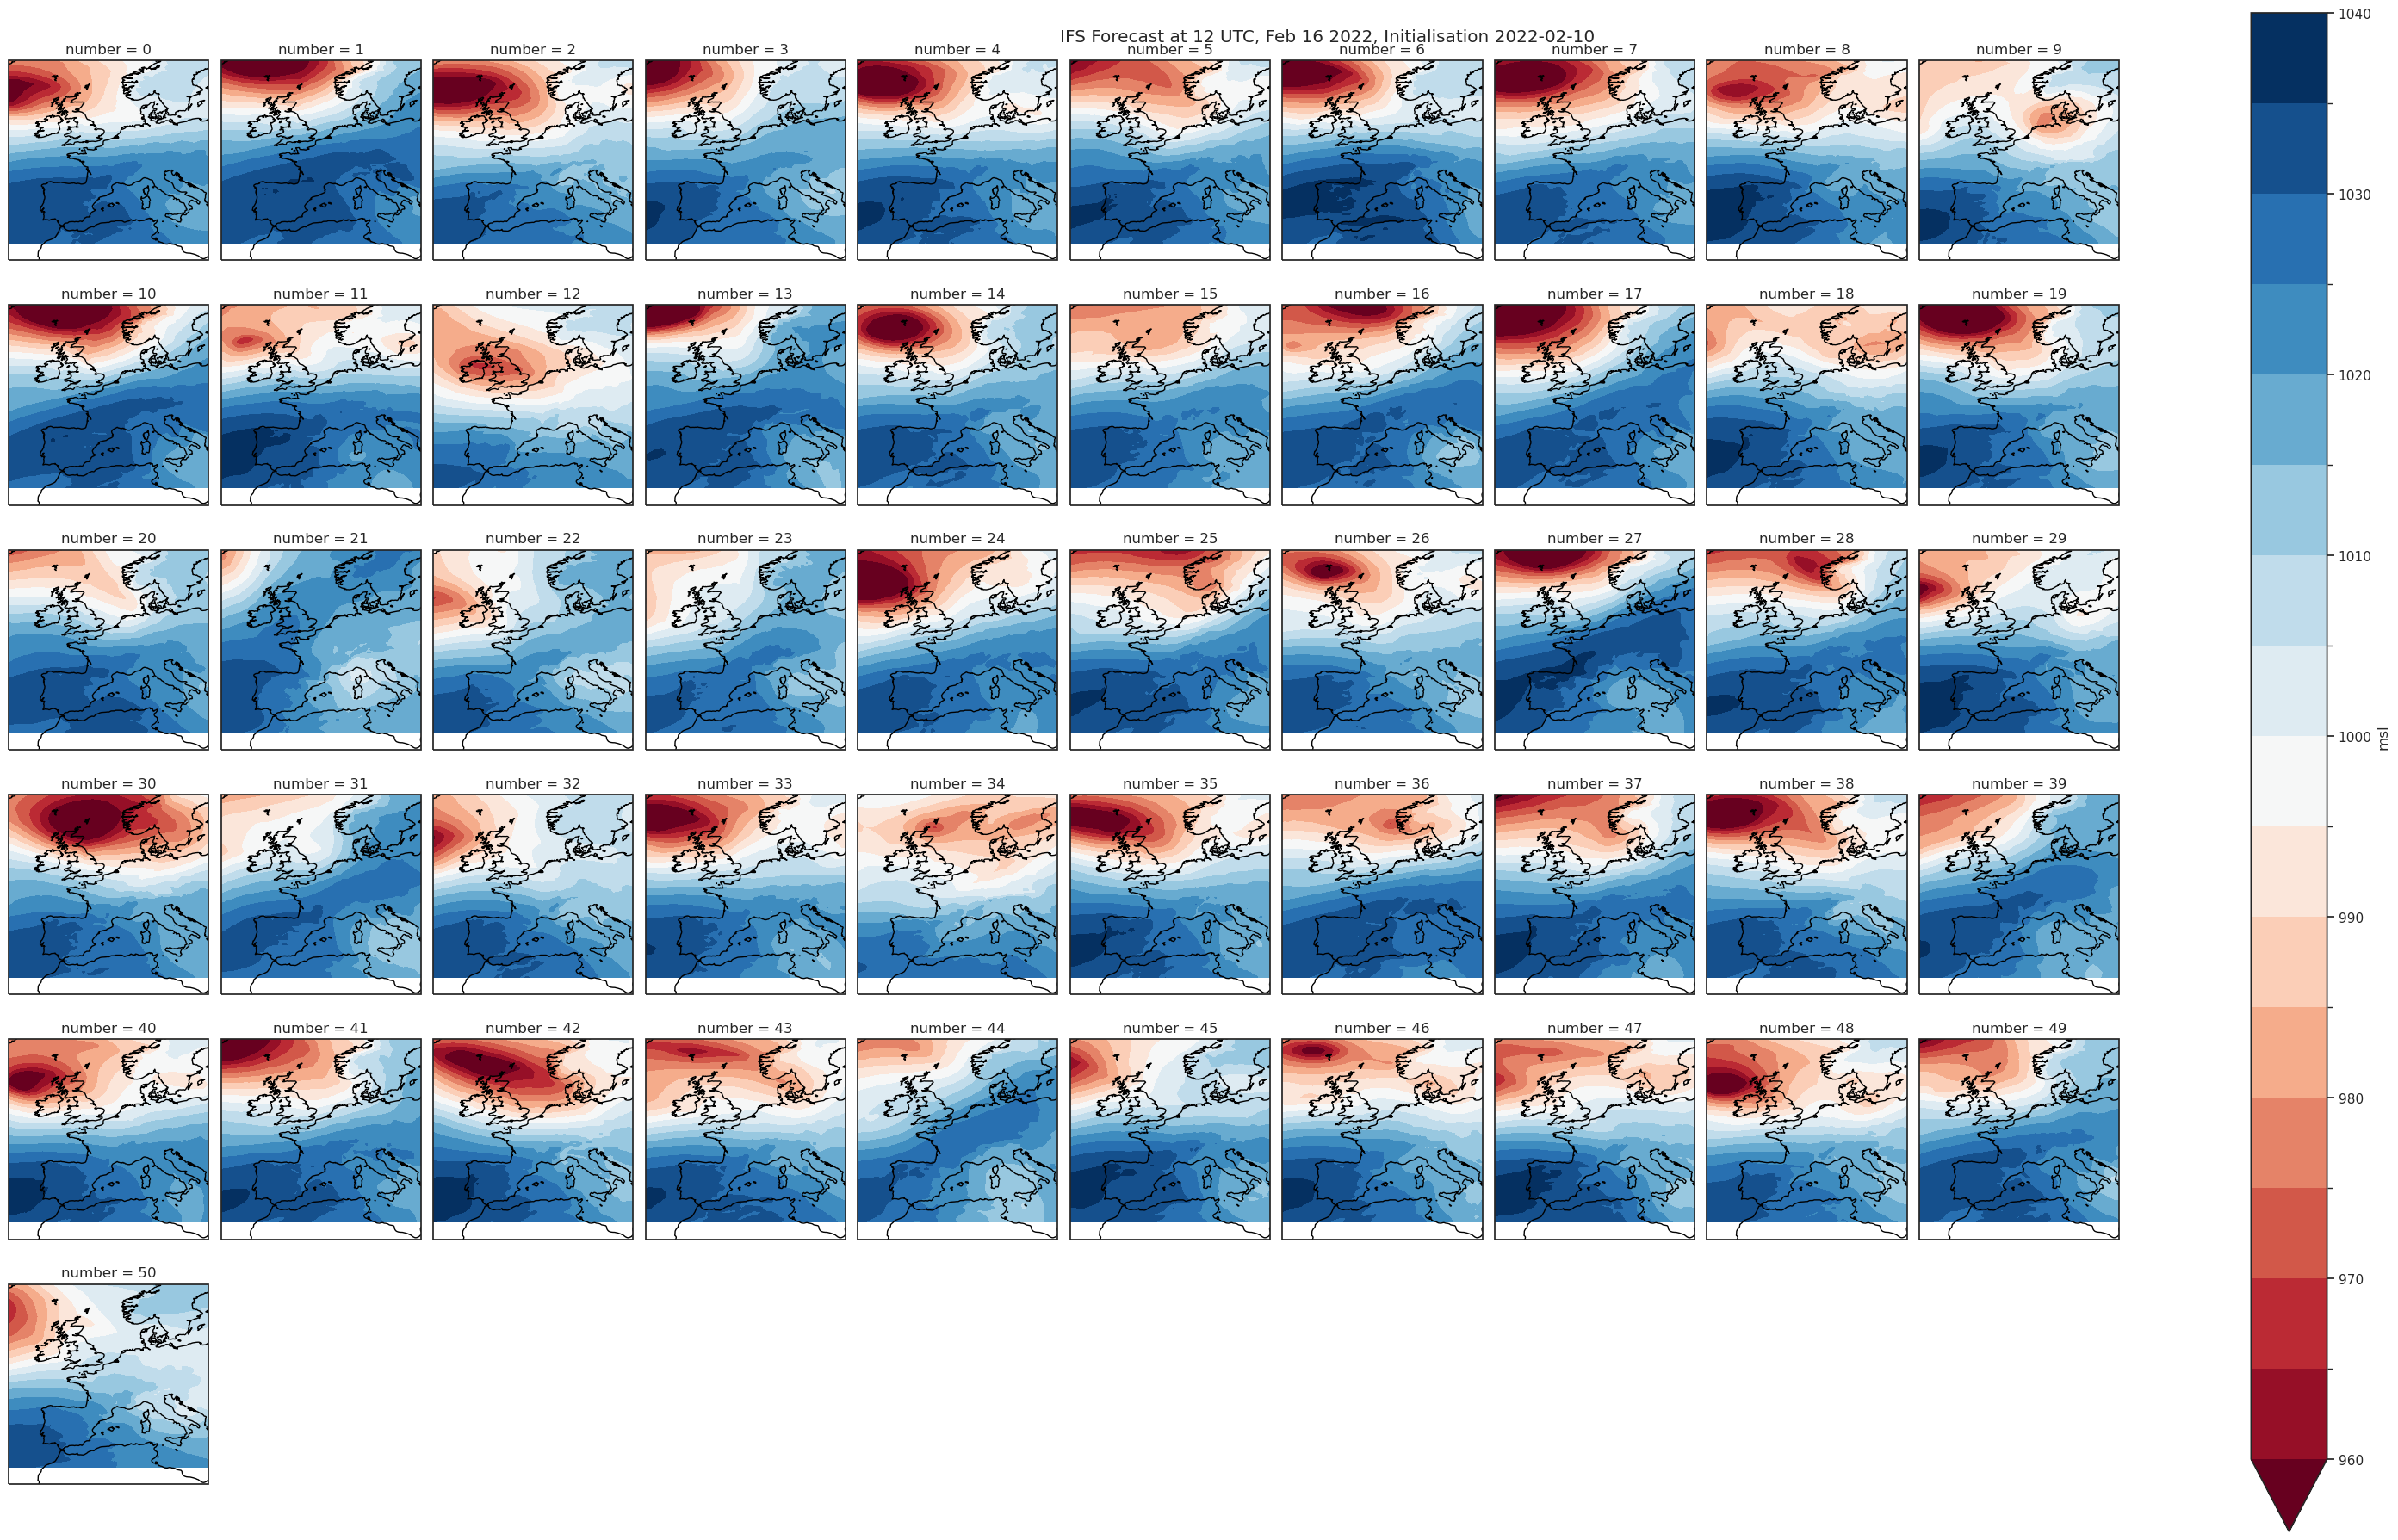

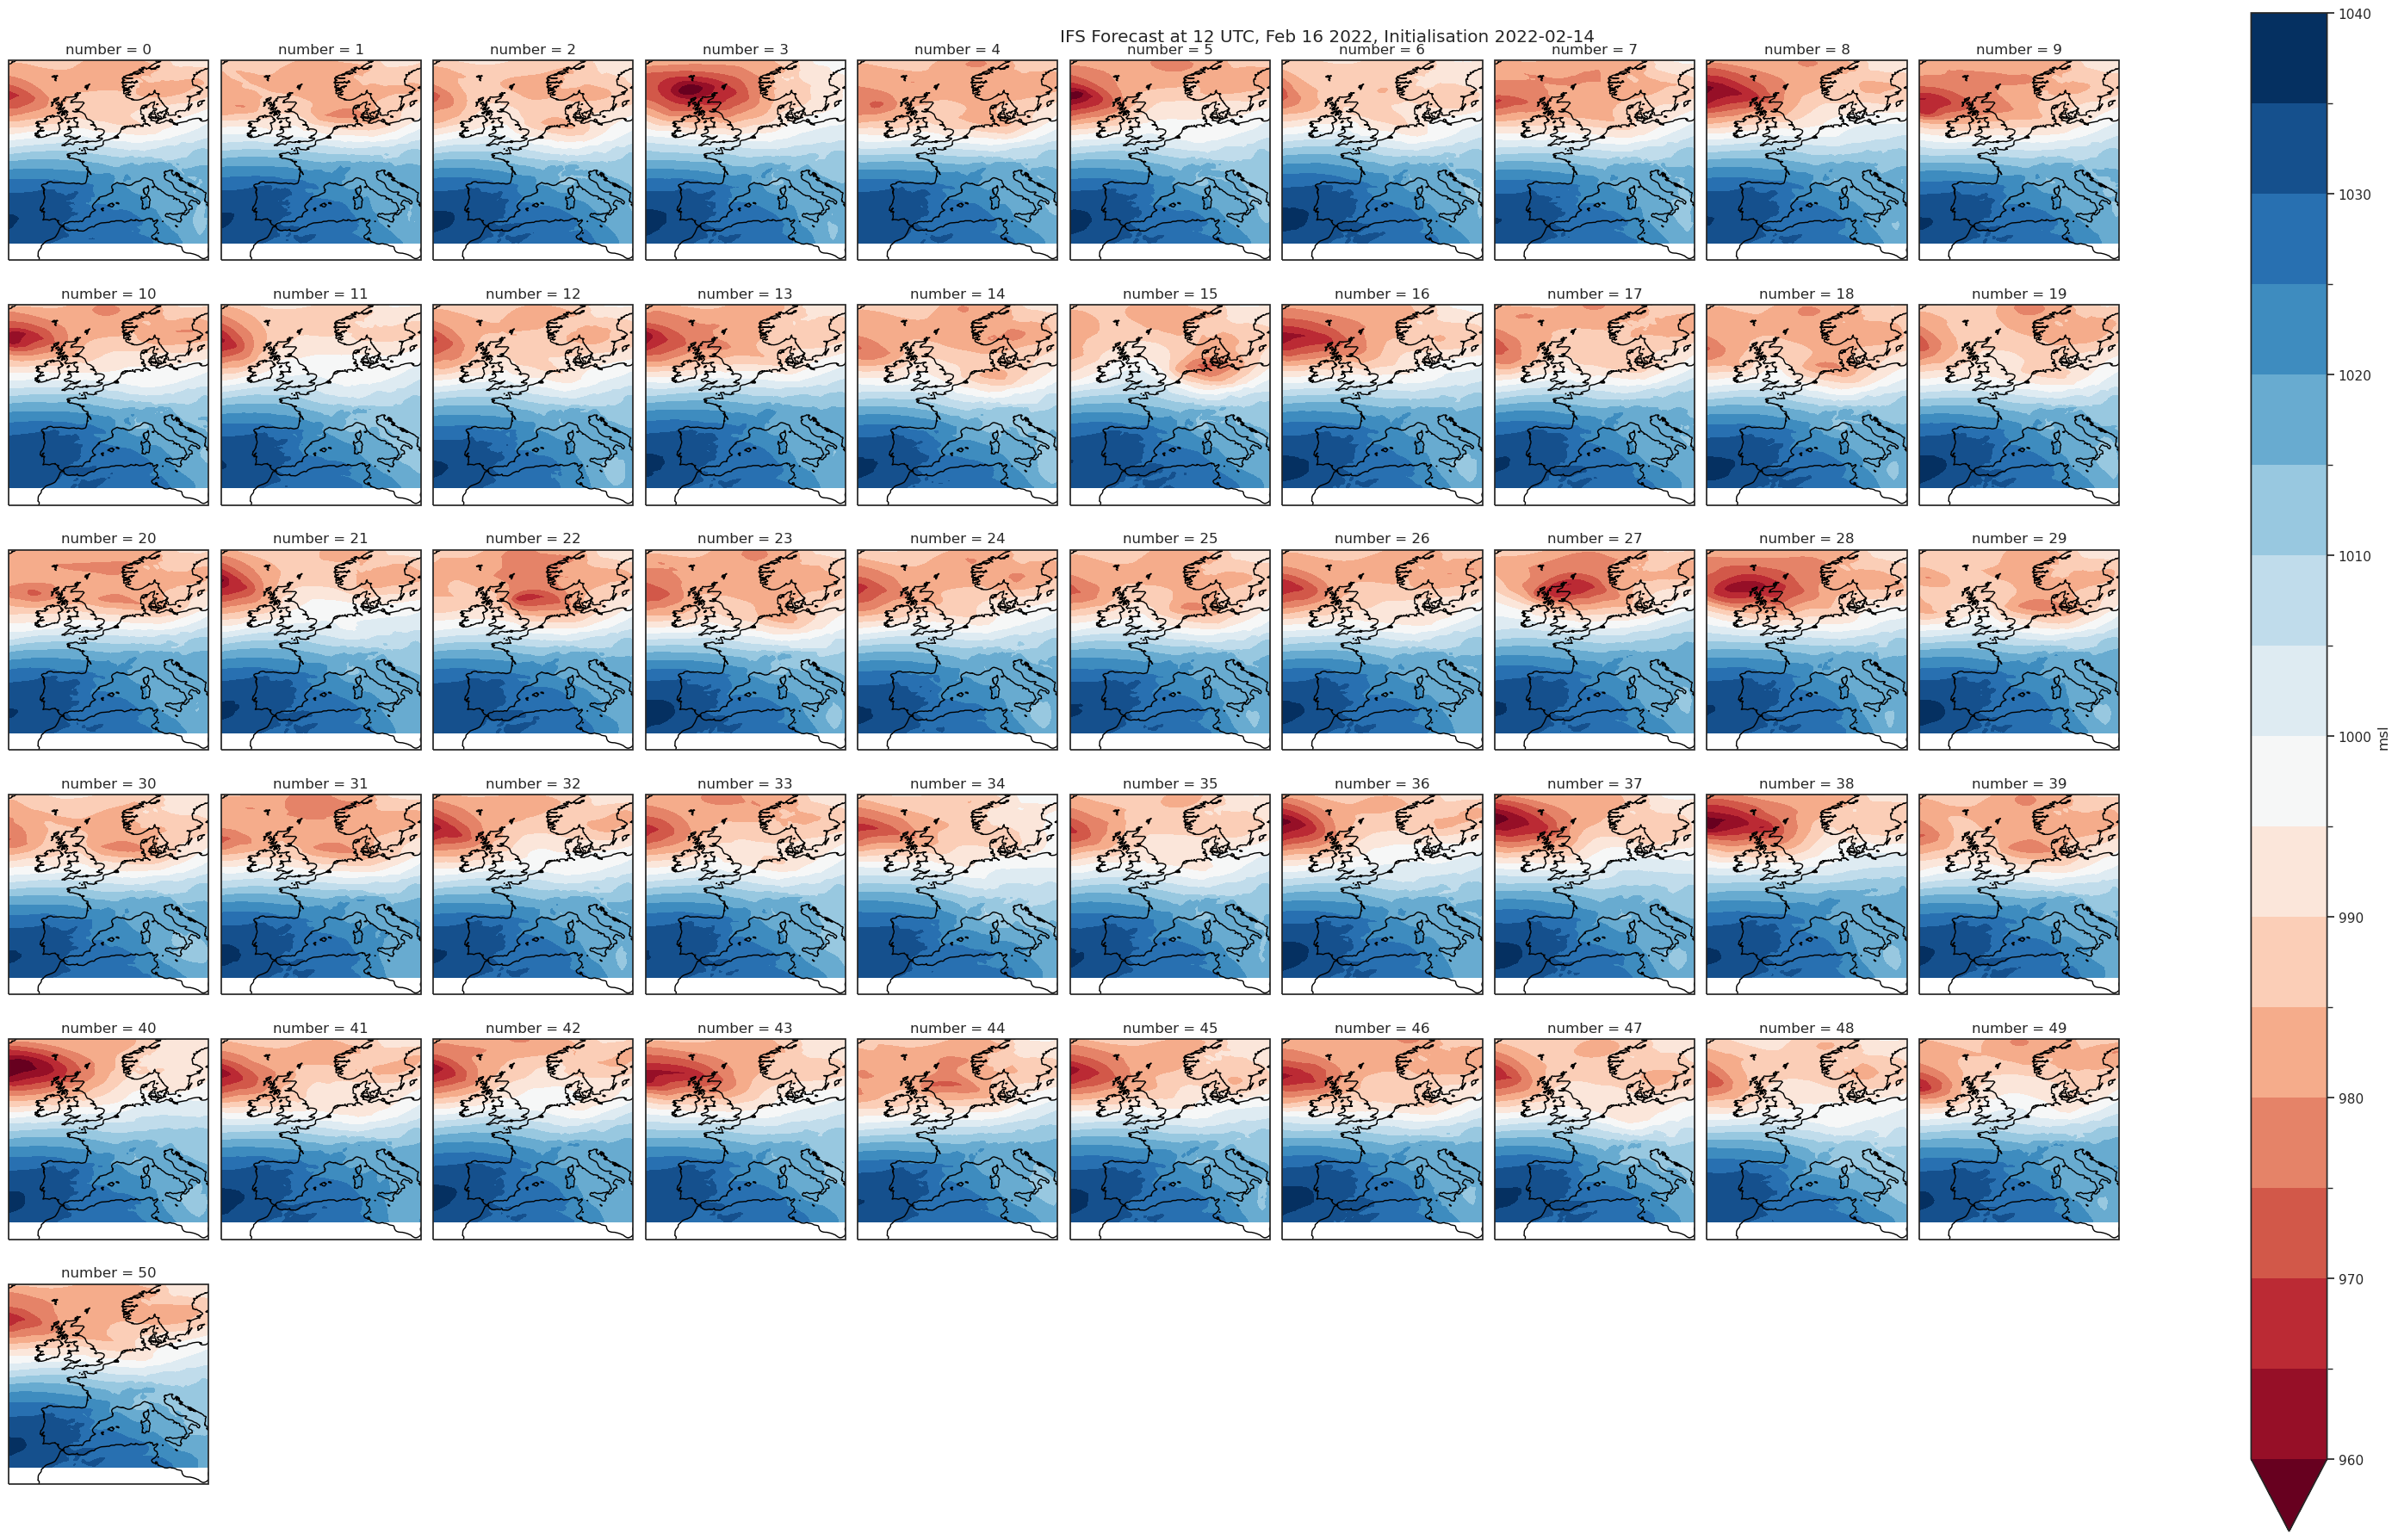

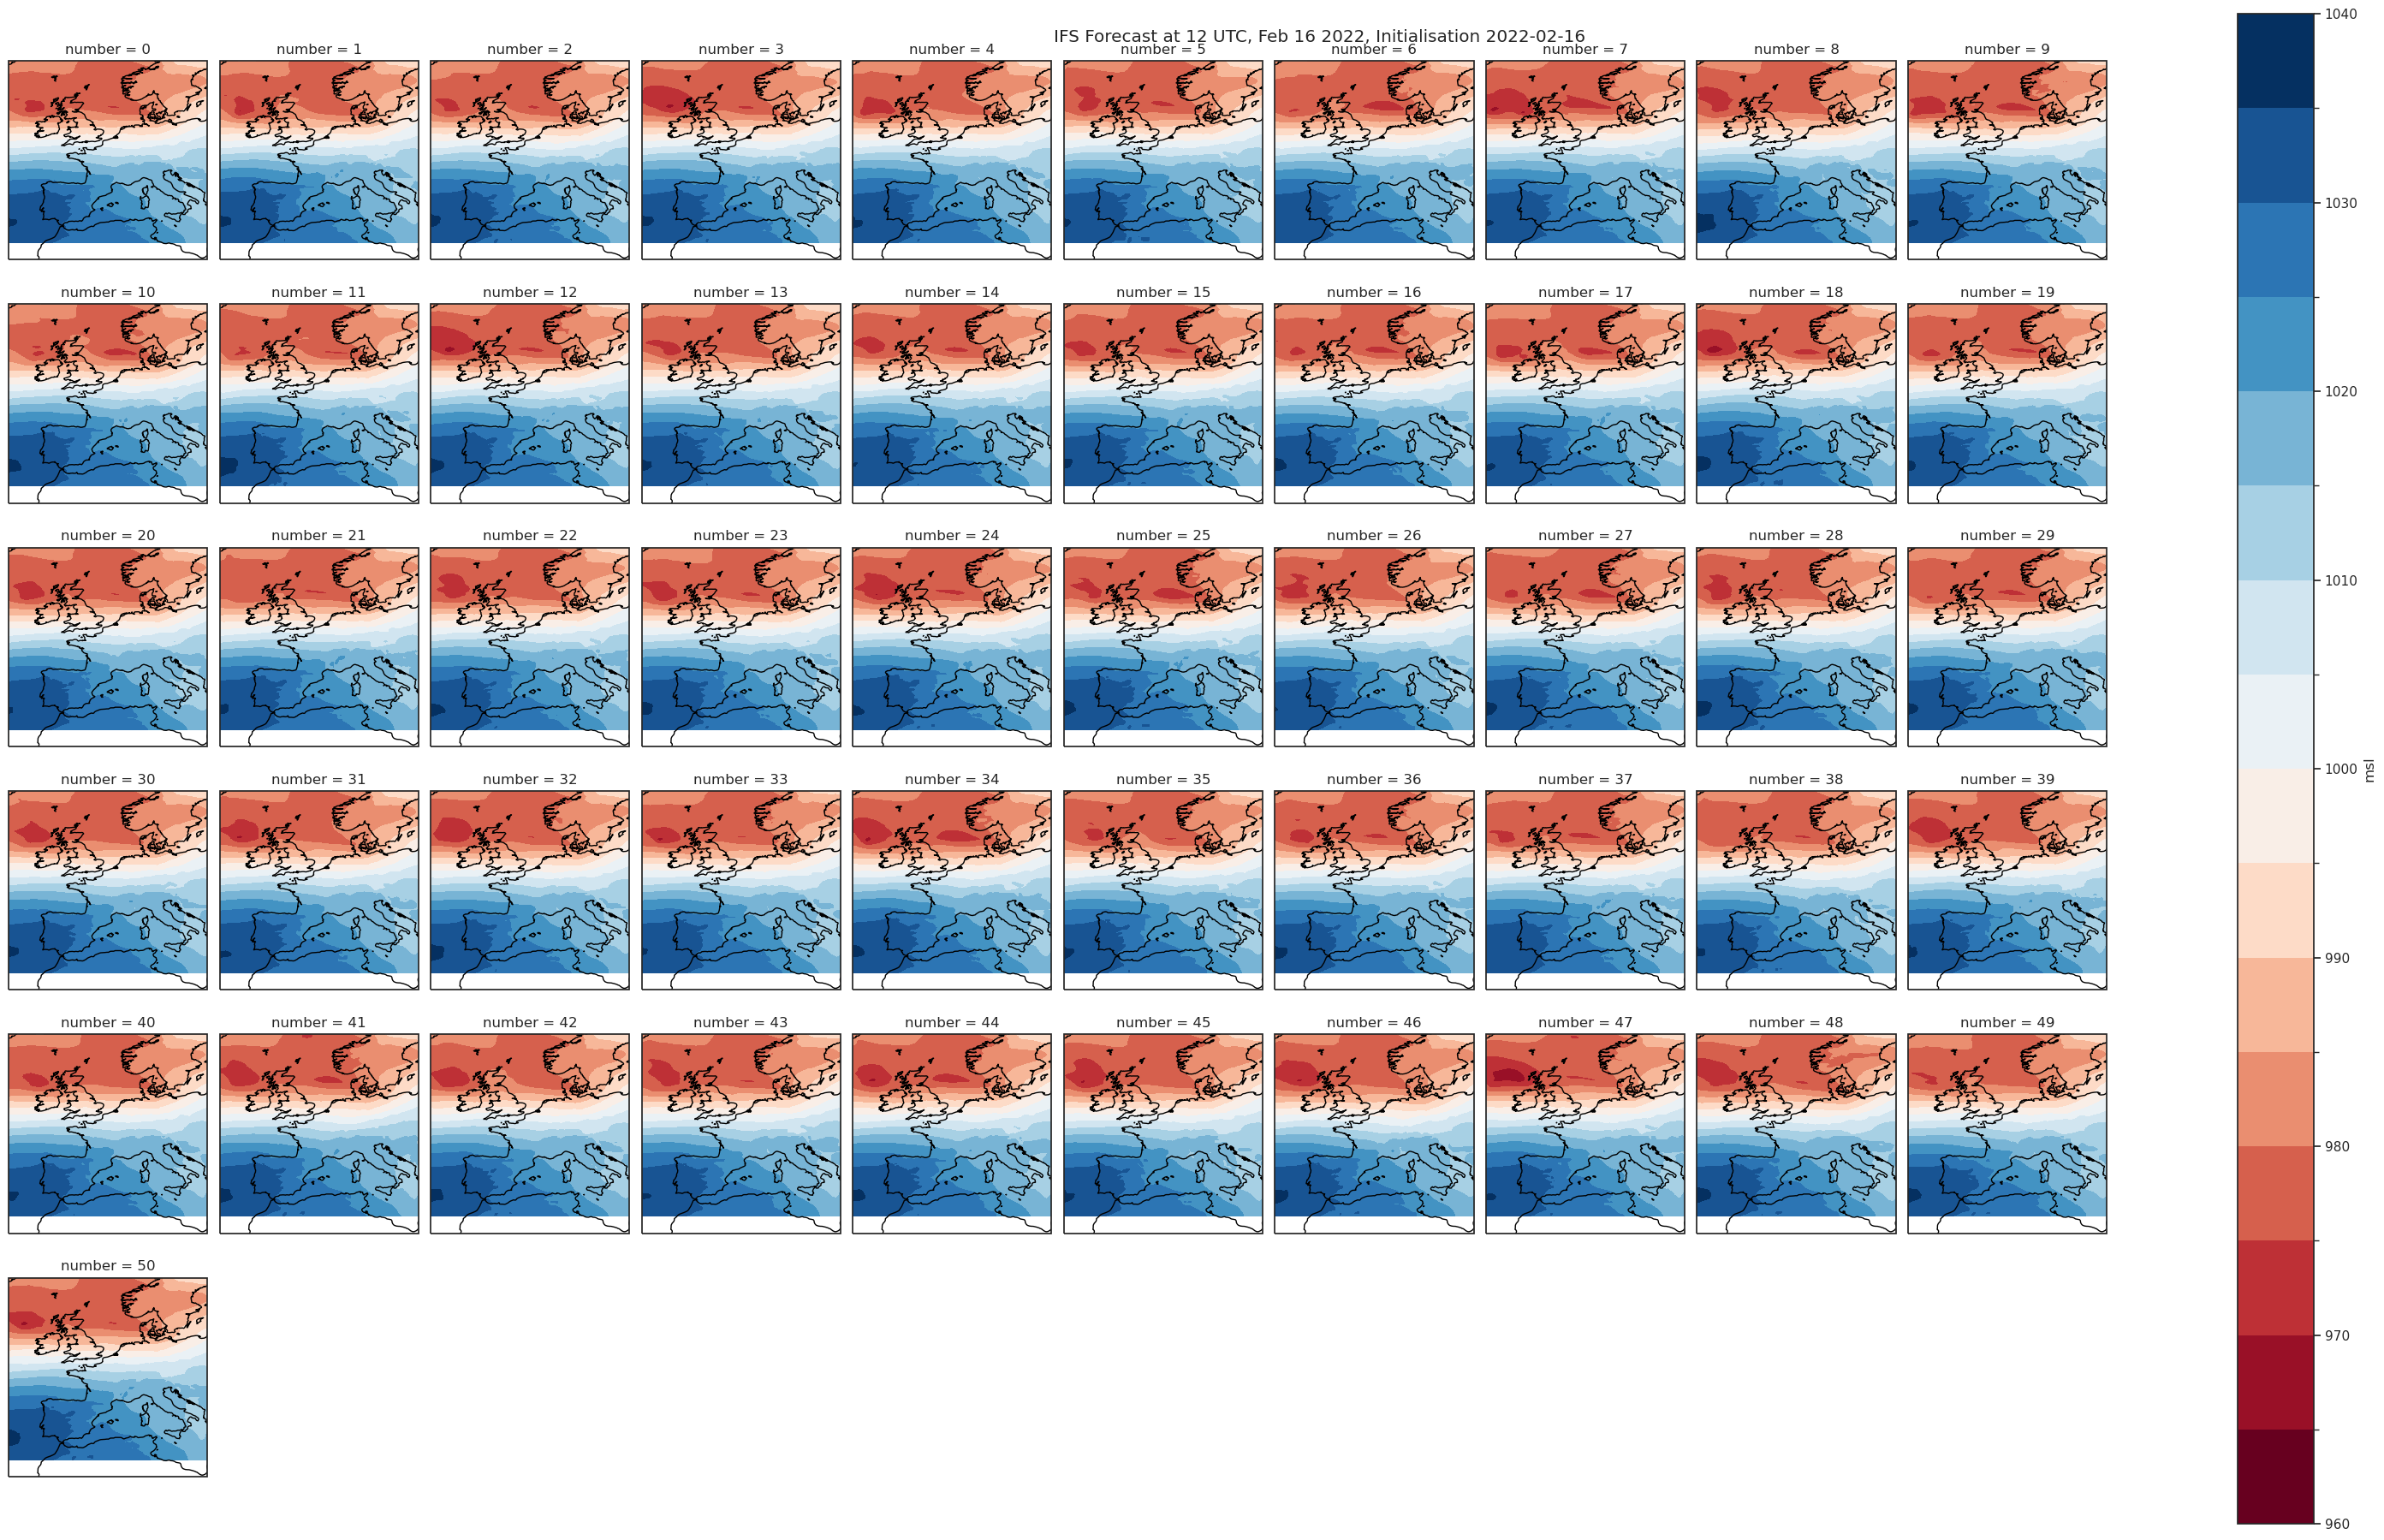

In [57]:
projection = ccrs.PlateCarree()

for id in inidate:

    #eps_msl = eps.sel(inidate=inidate,time='2022-02-18 12').sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).msl.squeeze()
    eps_msl_plot = eps_msl[id].sel(time='2022-02-16 12').plot.contourf(col='number',
                          col_wrap=10,
                          vmin=p_min,
                          vmax=p_max,
                          levels=17,
                          cmap='RdBu', 
                          subplot_kws = {"projection": projection})

    plt.suptitle('IFS Forecast at 12 UTC, Feb 16 2022, Initialisation '+ id)
    eps_msl_plot.map(lambda: plt.gca().coastlines())

    for i, ax in enumerate(eps_msl_plot.axs.flat):
        ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=projection)

    plt.savefig('figures/02_stamp_'+id+'_lon'+str(lon_min)+'-'+str(lon_max)+'_lat'+str(lat_min)+'-'+str(lat_max)+'.png')
    plt.savefig('figures/02_stamp_'+id+'_lon'+str(lon_min)+'-'+str(lon_max)+'_lat'+str(lat_min)+'-'+str(lat_max)+'.pdf')
    
    # plt.savefig('figures/05_stamp_'+np.datetime_as_string(inidate.values)[:10]+'_lon'+str(lon_min)+'-'+str(lon_max)+'_lat'+str(lat_min)+'-'+str(lat_max)+'.png')
    # plt.savefig('figures/05_stamp_'+np.datetime_as_string(inidate.values)[:10]+'_lon'+str(lon_min)+'-'+str(lon_max)+'_lat'+str(lat_min)+'-'+str(lat_max)+'.pdf')

<Figure size 640x480 with 0 Axes>

In [22]:
era5_2022 = xr.open_dataset('/gf3/predict2/AWH012_LEACH_NASTORM/DATA/ERA5/EU025/sfc/2022.nc')
era5_GUST = era5_2022.fg10.sel(time=slice('2022-02-07','2022-02-22'),latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max)).resample(time='1d').max().load()


era_at_12 = era5_2022.sel(time=era5_2022.time.dt.hour==12).sel(time=slice('2022-02-10','2022-02-21')).sel(latitude=slice(lat_max,lat_min),longitude=slice(lon_min, lon_max))


/home/l/luol/nobackups/miniconda3/envs/storm_dudley/lib/python3.9/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [23]:
era5_msl_plt = era_at_12.msl/100
era5_msl_plt

<xarray.DataArray 'msl' (time: 12, latitude: 129, longitude: 141)>
array([[[1013.82764, 1014.11017, 1014.3911 , ...,  982.85803,
          982.68787,  982.51776],
        [1014.44244, 1014.5725 , 1014.73615, ...,  983.8677 ,
          983.65735,  983.45514],
        [1014.9336 , 1014.95776, 1014.985  , ...,  984.7938 ,
          984.6253 ,  984.45514],
        ...,
        [1022.9626 , 1023.1231 , 1023.2434 , ..., 1027.189  ,
         1027.1713 , 1027.1906 ],
        [1023.0878 , 1023.2434 , 1023.3189 , ..., 1027.1263 ,
         1027.1055 , 1027.1263 ],
        [1023.3606 , 1023.4874 , 1023.5003 , ..., 1027.059  ,
         1027.0284 , 1027.0461 ]],

       [[1010.9384 , 1010.8068 , 1010.67194, ..., 1002.74896,
         1002.4889 , 1002.2257 ],
        [1010.85333, 1010.6832 , 1010.48096, ..., 1003.15344,
         1002.8886 , 1002.6286 ],
        [1010.489  , 1010.41675, 1010.34454, ..., 1003.48413,
         1003.2466 , 1003.0058 ],
...
        [1026.9594 , 1026.6962 , 1026.4137 , ..., 1022.3895 ,
         1022.48267, 1022.57733],
        [1026.619  , 1026.3414 , 1026.0669 , ..., 1022.5067 ,
         1022.60944, 1022.73627],
        [1026.3302 , 1026.03   , 1025.762  , ..., 1022.6769 ,
         1022.80365, 1022.94006]],

       [[1005.54834, 1005.89825, 1006.2466 , ...,  993.78424,
          993.8789 ,  993.9737 ],
        [1005.7907 , 1006.05396, 1006.3718 , ...,  993.4487 ,
          993.5708 ,  993.69116],
        [1006.18396, 1006.28186, 1006.37665, ...,  992.91907,
          993.0282 ,  993.14056],
        ...,
        [1026.929  , 1026.8662 , 1026.7892 , ..., 1018.2419 ,
         1018.14874, 1018.0669 ],
        [1026.5886 , 1026.502  , 1026.4216 , ..., 1018.49384,
         1018.38635, 1018.26917],
        [1026.2595 , 1026.144  , 1026.0461 , ..., 1018.68805,
         1018.55646, 1018.4393 ]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -15.0 -14.75 -14.5 -14.25 ... 19.5 19.75 20.0
  * latitude   (latitude) float32 65.0 64.75 64.5 64.25 ... 33.5 33.25 33.0
  * time       (time) datetime64[ns] 2022-02-10T12:00:00 ... 2022-02-21T12:00:00

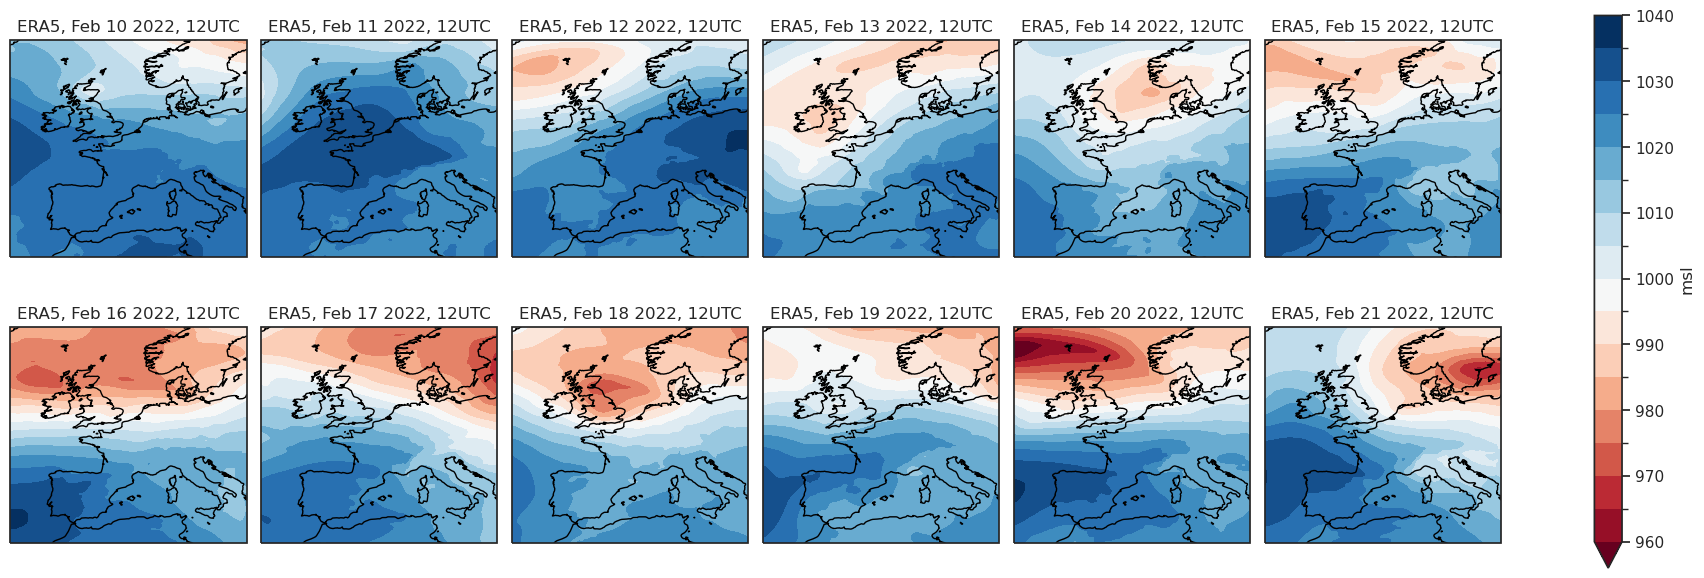

In [46]:
projection = ccrs.PlateCarree()
p_max = 1040
p_min = 960



msl_plot = era5_msl_plt.plot.contourf(vmin = p_min, vmax = p_max,
                                        col = 'time',
                                        col_wrap = 6,
                                        levels = 17,
                                        cmap = 'RdBu', 
                                        subplot_kws = {"projection": projection})

for i, ax in enumerate(msl_plot.axs.flat):
     ax.set_title("ERA5, Feb %d 2022, 12UTC" % int(i+10))

msl_plot.map(lambda: plt.gca().coastlines())

So, according to the plot, dudley def hit UK on Feb 16, not exactly 12 but maybe like 18
Actually there is not so much a difference